In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from gaia_spec import *
import glob

In [6]:
bps = lsst_filters()
bps.update(stubb_fitlers())

In [13]:
rf = glob.glob('*response*00.npz')
responses = []
teffs = []
for filename in rf:
    responses.append(gaia_response(restore_file=filename))
    teffs.append(filename.replace('.npz', '').split('_')[-1])
# response = gaia_response(restore_file='gaia_response_nonoise.npz')

(0, 5e-16)

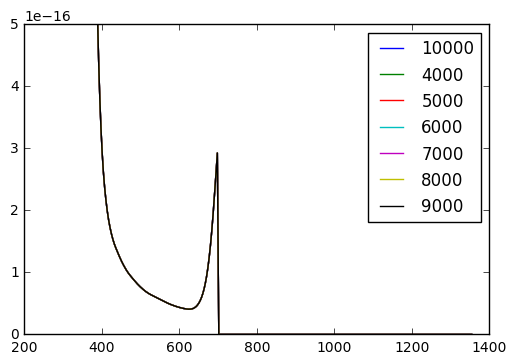

In [18]:
dir(responses[0])
for response,teff in zip(responses, teffs):
    plt.plot(response.blue_wavelen, response.blue_response, label='%s' % teff)
plt.legend()
plt.ylim([0,5e-16])

In [22]:
responses[0].red_response-responses[4].red_response

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [4]:
input_mag = 18
sed = Sed()
# Read in an SED that's solar-like, set to g=16, don't bother adding dust.
sed.read_close_SED(6000., 0., 4.4)
fNorm = sed.calcFluxNorm(input_mag, bps['g'])
sed.multiplyFluxNorm(fNorm)


Opening cache of LSST SEDs in:
/Users/yoachim/gitRepos/sims_photutils/cacheDir/lsst_sed_cache.p


KeyboardInterrupt: 

In [ ]:
plt.plot(sed.wavelen, sed.flambda*5.03e8*sed.wavelen*100)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$f_\lambda$ ')
plt.xlim([300,1000])
plt.title('Input Spectrum')

In [ ]:
workdir = 'plot_work'
gaia_observed = SED2GAIA(sed, workdir=workdir)


In [ ]:
observed_sed = ulysses2SED(data=gaia_observed, response=response)
not_nan = ~np.isnan(observed_sed.flambda)
observed_sed.flambda = np.interp(observed_sed.wavelen, observed_sed.wavelen[not_nan],
                                             observed_sed.flambda[not_nan])

In [ ]:
plt.plot(gaia_observed['BP_wave'], gaia_observed['noisySpec'][0]['BPNoisySpec'], 'b', label='BP')
plt.plot(gaia_observed['RP_wave'], gaia_observed['noisySpec'][0]['RPNoisySpec'], 'r', label='RP')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Flux (e$^{-1}$ s$^{-1}$)')
plt.title('GAIA Observed Spectrum')
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    plt.plot(bps[fn].wavelen, bps[fn].sb*gaia_observed['noisySpec'][0]['BPNoisySpec'].max()*.5, alpha=.5, linewidth=2)
 

In [ ]:
plt.plot(observed_sed.wavelen, observed_sed.flambda, label='Recovered')
plt.plot(sed.wavelen, sed.flambda, label='Input', linewidth=2, alpha=.5)
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$F_\lambda$')
plt.xlim([300,1100])
plt.title(r'$g=%.0f$ input star' % input_mag)
plt.ylim([0,sed.flambda.max()*1.1])
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    plt.plot(bps[fn].wavelen, bps[fn].sb*sed.flambda.max()*.5, alpha=.5, linewidth=2)
    

In [ ]:

print 'filter, input, recovered, diff (mmag)'
for fn in filters:
    inmag = sed.calcMag(bps[fn])
    outmag = observed_sed.calcMag(bps[fn])
    print '%s, %.2f, %.2f, %f' % (fn, inmag, outmag, (inmag-outmag)*1e3)

In [ ]:
def star2mags(teff, feH, logg, response=None, work_dir='temp_work'):
    # Let's see if I can understand the crazy shift with temperature
    filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
    sed.read_close_SED(6000., 0., 4.4)
    fNorm = sed.calcFluxNorm(input_mag, bps['g'])
    sed.multiplyFluxNorm(fNorm)
    gaia_observed = SED2GAIA(sed, workdir=workdir)
    observed_sed = ulysses2SED(data=gaia_observed, response=response)
    not_nan = ~np.isnan(observed_sed.flambda)
    observed_sed.flambda = np.interp(observed_sed.wavelen, observed_sed.wavelen[not_nan],
                                                 observed_sed.flambda[not_nan])
    inmags = []
    outmags = []
    for fn in filters:
        inmags.append(sed.calcMag(bps[fn]))
        outmags.append(observed_sed.calcMag(bps[fn]))
    return (inmags, outmags)


In [ ]:
hotin, hotout = star2mags(10000, 0, 4.4, response=response)
coldin, coldout = star2mags(1000, 0, 3., response=response)

In [ ]:
hotin, hotout